This notebook, unlike previous notebooks, uses the new shared saga code repo.  It also require py3.

# Imports/Setup 

In [126]:
import os
import sys
from glob import glob

import numpy as np

from astropy import units as u
from astropy import table
from astropy.coordinates import SkyCoord, UnitSphericalRepresentation, CartesianRepresentation, matrix_utilities

In [2]:
%matplotlib inline
from matplotlib import style, pyplot as plt

The below two cells build the saga repo and sets the path to look for it

In [3]:
startdir = !pwd
startdir = startdir[0]
%cd ../../saga
sagadir = !pwd
sagadir = sagadir[0]
!python setup.py build
%cd $startdir

/Users/erik/projects/saga/saga
running build
running build_py
copying SAGA/hosts/host_catalog.py -> build/lib/SAGA/hosts
/Users/erik/projects/saga/erik/ipython_notebooks


In [4]:
sagalibdir = os.path.join(sagadir, 'build/lib')
print('Adding', sagalibdir, 'to the python path')
sys.path.insert(0, sagalibdir)

import SAGA as saga

Adding /Users/erik/projects/saga/saga/build/lib to the python path


# Lists of hosts

In [5]:
db = saga.Database('/Users/erik/Dropbox/SAGA/')
hostcat = saga.HostCatalog(db)
hosttab = hostcat.load()

hosttab

NSAID,RA,Dec,PGC#,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,RA_sub,Dec_sub,othername,vhelio_sub,vhelio_err,distance_sub,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r_sub,r_err,A_r,M_r,i_sub,i_err,A_i,M_i,z_sub,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K_sub,K_err_sub,A_K,M_K,stellar_mass,sersic_n,MK_compiled,SAGA_name,coord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str11,object
145729,224.594,-1.09102,53499,1922.0,28.4038,11.9155,11.457,11.0653,9.49,7.693,0.019,0,-24.5739,-20.3514,48.4266,3.55266,12.164,0.983605,224.594,-1.09102,g1458227-010528,1922.0,-1,28.4038,0.520533,14.1855,0.0109577,0.245277,-18.3542,12.3155,0.000563506,0.191118,-20.1622,11.2899,0.000420059,0.132215,-21.1207,10.7733,0.000416391,0.0982496,-21.6016,10.3333,0.000670495,0.0730797,-22.0151,8.594,0.02,0.0410241,-23.7147,7.951,0.023,0.02598,-24.3439,7.713,0.031,0.0174743,-24.5597,19800000000.0,2.82806,-24.5739,Othello,"224.594,-1.09102"
150887,348.683,4.53406,70795,2689.0,37.019,11.9764,11.6247,11.3038,10.57,8.327,0.013,0,-24.5151,-20.8657,-50.6545,5.73166,10.189,0.98742,348.683,4.53406,NGC_7541,2689.0,-1,37.019,0.844612,13.5013,0.00257254,0.285874,-19.6741,12.1673,0.000503632,0.222751,-20.9126,11.3808,0.000382114,0.154098,-21.6316,10.9634,0.000777402,0.114511,-22.004,10.589,0.0018768,0.0851754,-22.3494,9.439,0.005,0.0478142,-23.451,8.757,0.006,0.0302801,-24.1194,8.351,0.007,0.0203666,-24.4949,25100000000.0,0.777359,-24.5151,Catch22,"348.683,4.53406"
140594,180.098,-1.10008,37845,1465.0,23.2487,11.1116,10.7406,10.4707,9.35,7.321,0.015,0,-24.511,-20.7204,59.2146,2.29212,12.669,0.985217,180.098,-1.10008,g1200236-010600,1465.0,-1,23.2487,0.508479,12.5696,0.00122745,0.112339,-19.3871,11.1341,0.00028931,0.0875336,-20.795,10.3932,0.000242571,0.0605553,-21.5041,9.98552,0.000254046,0.0449991,-21.896,9.68725,0.000379465,0.0334711,-22.1818,8.271,0.009,0.0187894,-23.5789,7.604,0.012,0.0118991,-24.24,7.33,0.015,0.00800337,-24.5004,20600000000.0,1.7545,-24.511,Alice,"180.098,-1.10008"
142722,194.863,14.1712,44600,1988.0,30.027,11.4723,11.0534,10.7367,9.93,7.907,0.016,0,-24.4806,-20.9153,76.9088,3.38499,10.768,0.987676,194.863,14.1712,NGC_4866,1988.0,-1,30.027,0.860169,13.5959,0.0034416,0.117999,-18.9324,11.6346,0.000660792,0.0919442,-20.8639,10.7622,0.000601578,0.0636066,-21.6974,10.3064,0.000701003,0.0472665,-22.1363,9.95885,0.000769763,0.0351576,-22.4698,8.856,0.017,0.0197361,-23.5504,8.186,0.018,0.0124986,-24.2145,7.917,0.02,0.00840664,-24.466,35000000000.0,2.18747,-24.4806,,"194.863,14.1712"
150578,346.236,12.3229,70419,2381.0,33.313,11.5503,11.1597,10.903,9.89,8.162,0.021,0,-24.4511,-21.0628,-42.8417,9.44227,14.017,0.987084,346.236,12.3229,NGC_7479,2381.0,-1,33.313,0.271001,13.4744,0.00466526,0.477309,-19.6406,11.9191,0.000694477,0.371916,-21.0857,11.0737,0.000516905,0.257289,-21.8076,10.5901,0.000479616,0.191194,-22.2242,10.2512,0.000863628,0.142213,-22.5123,9.194,0.011,0.0798329,-23.4982,8.508,0.011,0.0505571,-24.1574,8.202,0.019,0.034005,-24.4297,34400000000.0,2.01064,-24.4511,,"346.236,12.3229"
163956,206.33,41.7125,48767,2549.01,37.2285,12.2853,11.7813,11.3937,11.43,8.434,0.012,0,-24.4204,-20.5691,71.714,9.76207,9.739,0.985273,206.33,41.7125,13451914+4142447,2549.01,-1,37.2285,0.879017,14.1416,0.00298302,0.0288247,-18.7735,12.4646,0.00131613,0.02246,-20.4361,11.5252,0.000345898,0.0155377,-21.3595,10.9973,0.00034377,0.0115462,-21.8814,10.5916,0.000769146,0.00858824,-22.2824,9.511,0.013,0.00482111,-23.3483

In [331]:
np.choose?

In [9]:
msk1 = 8*u.hourangle < hosttab['coord'].ra
msk2 = hosttab['coord'].ra < 18*u.hourangle
msk3 = hosttab['coord'].dec > -10*u.deg
msk4 = hosttab['SAGA_name'] != ''

binomsk = msk1 & msk2 & msk3
namedbinomsk = msk1 & msk2 & msk3 & msk4

np.sum(binomsk), np.sum(namedbinomsk)

(56, 10)

In [338]:
np.choose(np.random.randn(100)>0, [np.random.randn(100),4]).astype('U')

array(['4.0', '4.0', '-0.8208258075857656', '4.0', '0.24962552458009',
       '4.0', '1.2534117889081722', '4.0', '4.0', '4.0', '4.0', '4.0',
       '4.0', '4.0', '0.34166297436596316', '4.0', '0.22510980367517794',
       '4.0', '4.0', '4.0', '4.0', '0.35435969807575635',
       '1.678949347882781', '-0.20174737840161958', '0.4581044484017311',
       '4.0', '4.0', '-1.061246764096021', '0.11388601829272206', '4.0',
       '4.0', '1.517714989103793', '-2.264612530386412',
       '-0.962768349782038', '4.0', '4.0', '-0.9232080464830247', '4.0',
       '4.0', '4.0', '4.0', '4.0', '1.4482363023340175',
       '-0.8680982209231194', '1.369971442240352', '-1.0045569601583695',
       '4.0', '4.0', '4.0', '4.0', '-1.1604546641683213',
       '-0.789647801951719', '4.0', '1.1960506638007622', '4.0', '4.0',
       '4.0', '4.0', '0.49219619977063367', '4.0', '-0.18761225609487772',
       '4.0', '0.6151376761227649', '0.4140838626736991',
       '-0.09014045369222295', '4.0', '-0.2056218688576

# Overlap with alternate imaging surveys 

## DECaLS

In [14]:
decals_path = os.path.join(os.environ['HOME'], 'astrodata', 'decals', 'dr5')

bricks_fn = os.path.join(decals_path, 'survey-bricks.fits.gz')
bricks_dr_fn = os.path.join(decals_path, 'survey-bricks-dr5.fits.gz')

In [15]:
bricks = table.Table.read(bricks_fn)
bricks_dr = table.Table.read(bricks_dr_fn)

In [195]:
bricks_in_dr = bricks[np.in1d(bricks['BRICKNAME'], bricks_dr['brickname'])]

In [206]:
def random_sample_cone(angle, n, ra0=0*u.deg, dec0=0*u.deg):
    phi = np.random.uniform(0, 2*np.pi, n)
    z = np.random.uniform(np.cos(angle), 1, n)
    s = np.sqrt(1-z**2)
    x = s * np.cos(phi)
    y = s * np.sin(phi)
    xyz = np.array([x, y, z])
    
    A = matrix_utilities.rotation_matrix(90*u.deg - dec0, 'y')
    B = matrix_utilities.rotation_matrix(180*u.deg - ra0, 'z')
    
    return CartesianRepresentation(B @ A @ xyz)

def host_overlap(hostrow, brickstocheck, environrad=300*u.kpc, precision=1e-2):
    host_ra = hostrow['coord'].ra
    host_dec = hostrow['coord'].dec
    host_distance = hostrow['distance']*u.Mpc
    
    if environrad.unit.is_equivalent(u.kpc):
        environrad = (environrad/host_distance).to(u.rad, u.dimensionless_angles())
    elif environrad.unit.is_equivalent(u.deg):
        pass
    else:
        raise u.UnitsError('invalid unit for environrad')
        
    n = int(np.ceil(1/precision))
    testpoints = random_sample_cone(environrad, n, host_ra, host_dec)
    testsc = SkyCoord(testpoints)
    
    msk_ra1 = brickstocheck['RA1'] < testsc.ra[:, np.newaxis].deg
    msk_ra2 = testsc.ra[:, np.newaxis].deg < brickstocheck['RA2']
    msk_dec1 = brickstocheck['DEC1'] < testsc.dec[:, np.newaxis].deg
    msk_dec2 = testsc.dec[:, np.newaxis].deg < brickstocheck['DEC2']
    match = msk_ra1 & msk_ra2 & msk_dec1 & msk_dec2
    
    havepoint = np.any(match, axis=0)
    
    return match

In [212]:
nbricks = []
frac = []
for row in hosttab[binomsk]:
    print('on', row['NSAID'], row['SAGA_name'])
    brick_match = host_overlap(row, bricks_in_dr)
    nbricks.append(np.sum(np.any(brick_match, axis=0)))
    frac.append(np.sum(np.any(brick_match, axis=1))/brick_match.shape[0])
    print('nbricks:', nbricks[-1], 'frac:', frac[-1])
np.sum(np.array(frac)>.9)/len(frac), len(frac)

on 145729 Othello
nbricks: 25 frac: 1.0
on 140594 Alice
nbricks: 34 frac: 1.0
on 142722 
nbricks: 22 frac: 1.0
on 163956 
nbricks: 0 frac: 0.0
on 165153 
nbricks: 0 frac: 0.0
on 135879 
nbricks: 0 frac: 0.0
on 144151 
nbricks: 0 frac: 0.0
on 163136 
nbricks: 15 frac: 1.0
on 164995 
nbricks: 0 frac: 0.0
on 147100 Odyssey
nbricks: 17 frac: 1.0
on 140458 
nbricks: 16 frac: 1.0
on 147606 
nbricks: 16 frac: 1.0
on 144121 
nbricks: 0 frac: 0.0
on 138201 
nbricks: 29 frac: 1.0
on 135440 
nbricks: 19 frac: 1.0
on 143856 
nbricks: 0 frac: 0.0
on 52773 
nbricks: 0 frac: 0.0
on 160302 
nbricks: 0 frac: 0.0
on 139467 
nbricks: 13 frac: 1.0
on 157374 
nbricks: 21 frac: 1.0
on 165980 
nbricks: 0 frac: 0.0
on 138642 
nbricks: 27 frac: 1.0
on 158541 
nbricks: 0 frac: 0.0
on 165082 
nbricks: 29 frac: 1.0
on 145398 
nbricks: 28 frac: 1.0
on 166313 Gilgamesh
nbricks: 26 frac: 1.0
on 166141 
nbricks: 31 frac: 1.0
on 69028 
nbricks: 0 frac: 0.0
on 141465 
nbricks: 19 frac: 1.0
on 145879 
nbricks: 22 frac: 

(0.5178571428571429, 56)

In [213]:
nbricks = []
frac = []
for row in hosttab[namedbinomsk]:
    print('on', row['NSAID'], row['SAGA_name'])
    brick_match = host_overlap(row, bricks_in_dr)
    nbricks.append(np.sum(np.any(brick_match, axis=0)))
    frac.append(np.sum(np.any(brick_match, axis=1))/brick_match.shape[0])
    print('nbricks:', nbricks[-1], 'frac:', frac[-1])
np.sum(np.array(frac)>.9)/len(frac), len(frac)

on 145729 Othello
nbricks: 24 frac: 1.0
on 140594 Alice
nbricks: 31 frac: 1.0
on 147100 Odyssey
nbricks: 20 frac: 1.0
on 166313 Gilgamesh
nbricks: 21 frac: 1.0
on 13927 Sopranos
nbricks: 22 frac: 1.0
on 165536 Dune
nbricks: 29 frac: 1.0
on 33446 StarTrek
nbricks: 0 frac: 0.0
on 85746 MobyDick
nbricks: 29 frac: 1.0
on 161174 ScoobyDoo
nbricks: 17 frac: 1.0
on 137625 Oz
nbricks: 33 frac: 1.0


(0.90000000000000002, 10)

## HSC 

In [44]:
import healpy

hscmap, hschead = healpy.read_map('../S16A_wide2_fdfc_i_limitmag_hp_frac_cut_0.02.fits', h=True)
hschead = dict(hschead)  #This is a VERY foolish healpy design choice!!

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [48]:
def query_disc_astropy(cen, rad, nside=hschead['NSIDE'], **kwargs):
    uvec = cen.represent_as(UnitSphericalRepresentation).represent_as(CartesianRepresentation).xyz
    return healpy.query_disc(nside, uvec, rad.to(u.radian).value)

In [214]:
nametofrac_environs = {}
nametofrac_1deg = {}
for row in hosttab:
    cen = row['coord']
    rad = ((300*u.kpc)/(row['distance']*u.Mpc)).to(u.arcmin, u.dimensionless_angles())
    name = row['SAGA_name']
    if name == '':
        name = 'NSA' + str(row['NSAID'])
    
    host_pix = query_disc_astropy(cen, rad)
    nametofrac_environs[name]= np.sum(hscmap[host_pix])/len(host_pix)
    
useful_nametofrac_environs = {k:v for k,v in nametofrac_environs.items() if v != 0}
useful_nametofrac_environs

{'Alice': 0.75620229007633588, 'Dune': 1.0, 'Othello': 0.66309778729478941}

In [242]:
for row in hosttab[np.in1d(hosttab['SAGA_name'], list(useful_nametofrac_environs.keys()))]:
    print(row['SAGA_name'], row['coord'].ra.wrap_at(180*u.deg).deg, row['coord'].dec.deg)

Othello -135.406 -1.09102
Alice -179.902 -1.10008
Dune -138.454 -0.222942


Note that *only* Alice has real data - the rest is "planned"

### Sanity Check 

The following query was run on HSC PDR1:
```

SELECT
        object_id
        ,ra
        ,DEC
        ,gmag_sinc
        ,gmag_sinc_err
        ,rmag_sinc
        ,rmag_sinc_err
        ,imag_sinc
        ,imag_sinc_err
        ,gmag_sinc - rmag_sinc AS g_r
        ,rmag_sinc - imag_sinc AS r_i
    FROM
        pdr1_<WHICH>.forced
    WHERE
        rmag_sinc < 21
        AND rmag_sinc - imag_sinc BETWEEN -0.5 AND 0.5
        AND gmag_sinc - rmag_sinc < 2.0
;
```
with `<WHICH>` being udeep, deep, and wide.  Make sure the only thing that has a catalog entry near it is Alice.

In [251]:
udeep = table.Table.read('hsc_alllt21_udeep.csv.gz', format='ascii')
deep = table.Table.read('hsc_alllt21_deep.csv.gz', format='ascii')
wide = table.Table.read('hsc_alllt21_wide.csv.gz', format='ascii')

allhscs = table.vstack([udeep, deep, wide])
allhscs

object_id,ra,dec,gmag_sinc,gmag_sinc_err,rmag_sinc,rmag_sinc_err,imag_sinc,imag_sinc_err,g_r,r_i
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
37484559004074122,34.9335872474,-5.63930407936,19.572094,0.00167754071,18.872776,0.00155809359,18.4833183,0.00126357947,0.699317932,0.389457703
37484559004074128,35.007400688,-5.63847832955,18.7620068,0.00102609256,18.3204193,0.00102432456,18.7646523,0.00163186796,0.441587448,-0.444232941
37484559004074140,34.9839707931,-5.63695020399,21.7254505,0.00981343817,20.9795456,0.00966036506,20.5662937,0.00758231245,0.745904922,0.413251877
37484559004074234,34.9812475349,-5.63046200861,20.0842876,0.00241828128,19.0970211,0.00187326351,18.7005138,0.00151360745,0.987266541,0.396507263
37484559004074297,35.0210733283,-5.62839921841,21.6440926,0.00925779901,20.8594284,0.00872357469,20.5057602,0.00732560875,0.784664154,0.353668213
37484559004074346,34.9125261812,-5.62635741508,21.6343727,0.00848574191,20.6335526,0.00668525044,20.1862679,0.00403645216,1.00082016,0.447284698
37484559004074404,35.0348231744,-5.62387766638,20.9874725,0.00531970244,20.2799358,0.00525719766,19.9842377,0.00464576297,0.707536697,0.295698166
37484559004074652,34.8803559155,-5.60849787947,21.3354282,0.00398692116,20.3638687,0.00298373797,19.9845657,0.0021697036,0.971559525,0.379302979
37484559004074721,34.8714731815,-5.60303105706,20.0524025,0.00136276113,19.4605064,0.00134896813,19.2511349,0.00114266912,0.591896057,0.209371567


In [254]:
hscscs = SkyCoord(allhscs['ra']*u.deg, allhscs['dec']*u.deg)

In [256]:
idx, d2d, d3d = hosttab['coord'].match_to_catalog_sky(hscscs)

In [280]:
environs_arcmin = ((300*u.kpc)/(hosttab['distance']*u.Mpc)).to(u.arcmin, u.dimensionless_angles())

for i, row in enumerate(hosttab[d2d < environs_arcmin*2]):
    print(environs_arcmin[d2d < environs_arcmin*2][i].value, d2d[d2d < environs_arcmin*2][i].arcmin)
    print(row['SAGA_name'], row['coord'].ra.wrap_at(180*u.deg).deg, row['coord'].dec.deg)

44.36050322106104 0.028584927437916633
Alice -179.902 -1.10008
34.94023848233826 45.7469565501222
Sopranos -179.324 1.9768
40.614821179053976 48.486946420914485
Dune -138.454 -0.222942
29.663536279258206 11.066673253525401
AnaK -5.869000000000028 0.297265


In [304]:
anakrow = hosttab[hosttab['SAGA_name']=='AnaK']
anakrow

NSAID,RA,Dec,PGC#,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,RA_sub,Dec_sub,othername,vhelio_sub,vhelio_err,distance_sub,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r_sub,r_err,A_r,M_r,i_sub,i_err,A_i,M_i,z_sub,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K_sub,K_err_sub,A_K,M_K,stellar_mass,sersic_n,MK_compiled,SAGA_name,coord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str11,object
61945,354.131,0.297265,71883,2556.76,34.7674,12.0858,11.7031,11.4059,11.65,9.3,0.03,0,-23.4059,-20.6201,-57.1915,9.4085,12.75,0.988686,354.131,0.297265,23363144+0017501,2556.76,-1,34.7674,0.18565,13.9881,0.00362979,0.146192,-18.8929,12.2354,0.000889212,0.113912,-20.607,11.3966,0.000934616,0.0788036,-21.3986,10.9721,0.000835867,0.0585595,-21.8018,10.6397,0.00123655,0.0435575,-22.1167,10.239,0.019,0.0244515,-22.4891,9.594,0.025,0.0154848,-23.128,9.312,0.027,0.0104152,-23.3869,24700000000.0,6.0,-23.4059,AnaK,"354.131,0.297265"


In [292]:
idxcat, _, d2d, _ = anakrow['coord'].search_around_sky(hscscs, environs_arcmin[hosttab['SAGA_name']=='AnaK'][0])

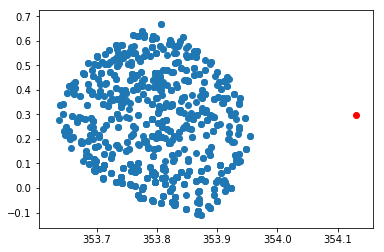

In [307]:
plt.scatter(allhscs[idxcat]['ra'],allhscs[idxcat]['dec'])
plt.scatter([anakrow['coord'].ra.deg], [anakrow['coord'].dec.deg], c='r')

In [ ]:
np.ptp(allhscs[idxcat]['ra'])

In [329]:
ra_range = np.ptp(allhscs[idxcat]['ra'])*u.deg
dec_range = np.ptp(allhscs[idxcat]['dec'])*u.deg
print(ra_range.to(u.arcmin), dec_range.to(u.arcmin))
max_cat_area = ra_range * dec_range
environs_area = (np.pi*environs_arcmin[hosttab['SAGA_name']=='AnaK']**2).to(u.deg**2)[0]
max_cat_area/environs_area

18.976656387330877 arcmin 46.68255134669514 arcmin


<Quantity 0.3204634900042614>